### Travel mode detection based on the results of anchor identification

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import pyproj
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_rows',300)

In [2]:
class Data(object):
    def __init__(self):
        self.base_path = 'D:\\ZhpyFile\\Travel_Survey_Analysis'
        self.pred_path = os.path.join(self.base_path,'Trip_Segment_in_pred')
        self.log_path = os.path.join(self.base_path,'Trip_Segment_in_log')
        self.mode_match = os.path.join(self.base_path,'mode_match.csv')
        self.pred_files = os.listdir(self.pred_path)
        self.log_files = os.listdir(self.log_path)
        
    def pred_dates(self):
        # all dates in pred file
        pdate = set(map(lambda x: x.split('_')[0],self.pred_files))
        return pdate
    
    def log_dates(self):
        # all dates in log file
        ldate = set(map(lambda x: x.split('_')[0],self.log_files))
        return ldate
    
    def unrecord_files(self):  
        # several trajectories that not recored in logs
        pdate = self.pred_dates()
        ldate = self.log_dates()
        return pdate - ldate

    def get_pred_file_mode(self):
        # get the pred files and modes which storaged in mode_match.csv
        # mode_match.csv lists travel modes of each original file
        try:
            return pd.read_csv(self.mode_match).dropna()[['pred_file','adjust']].values.tolist() # list, [file_name, travel_mode]
        except FileNotFoundError:
            print('The file has been moved.')

    def random_split_data(self, test_size):
        # randomly split pred data into two parts for training and test
        files, modes = zip(*self.get_pred_file_mode())
        train_data,test_data,train_mode,test_mode = train_test_split(files,modes,shuffle=True,test_size=test_size,random_state=1)
        
        # print the number
        for mode in set(train_mode):
            print(mode.ljust(9, ' '),str(train_mode.count(mode)).ljust(3,' '),test_mode.count(mode))
        print('\n')
        return sorted(train_data),sorted(test_data)
    
    def save_dataset(self,data_set,data_name='train'):
        fpath = os.path.join(self.base_path,'Dataset')
        if not os.path.exists(fpath): os.makedirs(fpath)
        with open(fpath +'\\'+ data_name+'.txt','w') as fw:
            for element in data_set:
                fw.write(element+'-')

    def read_dataset(self,data_name='train'):
        fpath = os.path.join(self.base_path,'Dataset',data_name+'.txt')
        with open(fpath,'r') as fr:
            data_set = fr.read()
        data_set = data_set[:-1].split('-')
        return data_set

In [3]:
class Preprocess(object):
    def __init__(self):
        self.data_path = 'D:\\ZhpyFile\\Travel_Survey_Analysis\\Trip_Segment_in_pred'

    def read_track(self,file):
        self.file = file
        cols = ['datetime','lon','lat','signal','true_mode','movement']
        with open(os.path.join(self.data_path,file)) as f:
            df = pd.read_csv(f,header=None,names=cols,usecols=['datetime','lon','lat','signal','true_mode'])
        df = df[df.lat<40]  # filter some noises whose lats are over 40
        df.drop_duplicates(inplace=True)
        df.datetime = df.datetime.apply(pd.to_datetime)
        df.sort_values('datetime',inplace=True)
        df['true_mode'] = df['true_mode'].apply(lambda r: self.transform_mode(r))
        df['true_mode'] = df['true_mode'].apply(lambda r: self.transform_mode_number(r))
        return df
    
    def fill_missing(self,df):
        # input: df --- read file
        length = len(df)
        duration = (df.loc[length-1,'datetime']-df.loc[0,'datetime']).seconds+1
        if length == duration:
#             print('{}:\t轨迹数据完整无缺失.'.format(self.file))
            df['missing'] = 0
        else:
#             print('{};\t轨迹数据缺失,缺失比例 {}，插值补全.'.format(self.file,length/duration))

            df.set_index('datetime',inplace = True)
            all_time = pd.date_range(df.index.min(),df.index.max(),freq='s')
            df = df.reindex(all_time)
            df['missing'] = df.lon.apply(lambda x: 1 if np.isnan(x) else 0)
            df.reset_index(inplace=True)
            df.rename(columns={'index':'datetime'},inplace=True)
            mark = df.missing.diff().fillna(0)
            marks = mark[mark!=0].index.tolist()
            starts = (np.array(mark[mark==1].index)-1).tolist()
            ends = mark[mark==-1].index.tolist()
            missing_num = len(starts)
            for i in range(missing_num):
                df.loc[starts[i]:ends[i],'lon'] = np.linspace(df.loc[starts[i],'lon'],df.loc[ends[i],'lon'],ends[i]-starts[i]+1)
                df.loc[starts[i]:ends[i],'lat'] = np.linspace(df.loc[starts[i],'lat'],df.loc[ends[i],'lat'],ends[i]-starts[i]+1)
            df.signal.fillna(0,inplace=True)
            df.drop('missing',axis=1,inplace=True)
        return df

    def utm_convert(self,LON,LAT,ZONE):
        p = pyproj.Proj(proj='utm',zone=ZONE, ellps='WGS84')  
        xx, yy =p(LON,LAT)
        return [xx, yy]

    def features(self,df):
        # velocity, acceleration, heading change rate
        df['time'] = df.datetime.apply(lambda r: datetime.time.strftime(r.time(),'%H:%M:%S'))
        df[['x','y']] = df[['lon','lat']].apply(lambda r: self.utm_convert(r.lon,r.lat,ZONE=51),axis=1)  # Shanghai ZONE=51
        df['dist'] = (df[['x','y']].diff().fillna(0)**2).sum(axis=1)**0.5
        df['speed'] = df['dist'].copy()
        df['accelerate'] = df['dist'].diff().fillna(0)
        df['jerk'] = df['accelerate'].diff().fillna(0)
        df['bearing'] = pd.Series(np.arctan((df.y.diff().fillna(0)/df.x.diff().fillna(1)).values))
        df['bear_rate'] = df['bearing'].diff().fillna(0)*180/math.pi
        df.drop('bearing',axis=1,inplace=True)
        return df
    
    def transform_mode(self,mode):
        if mode in ['eating','entertainment','home','other','school','shopping','work','visit','study','station']: return 'static'
        elif mode == 'unrecord': return 'car'         
        else: return mode
    
    def transform_mode_number(self,mode):
        # 将各种活动、方式统一为0~5数字
        if mode == 'static': return 0
        elif mode == 'walk': return 1
        elif mode == 'bicycle': return 2
        elif mode == 'bus': return 3
        elif mode in ['car','taxi']: return 4
        elif mode == 'subway': return 5
        else: print('The mode of {} is not exist.'.format(mode))

In [4]:
class Segmentation(object):
    # split trajectory into fix_length parts
    def __init__(self,step_size,start_point,overlap_rate):
        self.step_size = step_size
        self.start_point = start_point
        self.overlap_rate = overlap_rate
        
    def split_into_segments(self,df):
        # confirm the index of dataframe start at 0
        df.reset_index(drop=True,inplace=True)
        
        start = self.start_point
        step = self.step_size
        overlap = self.overlap_rate * self.step_size
        lens = df.index.max()
        segments = dict()
        for i in range(lens+1):
            if lens - (start+(step-overlap)*i+step-1) >= 0:
                segments[i] = df.loc[start+(step-overlap)*i:start+(step-overlap)*i+step-1]
            elif lens - (start+(step-overlap)*i+step-1) < 0 and lens - (start+(step-overlap)*i+step-1) >= step/2:
                segments[i] = df.loc[start+(step-overlap)*i:len(df)]
            else:
                break
        return segments
    
    def segments_features(self,panel):
        # calculate features of segmental dataframe (followed by the split)
        dist = []
        speed_15,speed_95,speed_mean = [],[],[]
        acc_15,acc_95,acc_mean = [],[],[]
        jerk_15,jerk_95,jerk_mean = [],[],[]
        head_15,head_95,head_mean = [],[],[]
        signal = []
        trueMode = []
        for key in sorted(panel.keys()):
            dist.append(panel[key].dist.sum())
            speed_15.append(panel[key].speed.quantile(0.15))
            speed_95.append(panel[key].speed.quantile(0.95))
            speed_mean.append(panel[key].speed.mean())
            acc_15.append(panel[key].accelerate.abs().quantile(0.15))
            acc_95.append(panel[key].accelerate.abs().quantile(0.95))
            acc_mean.append(panel[key].accelerate.abs().mean())   
            jerk_15.append(panel[key].jerk.abs().quantile(0.15))
            jerk_95.append(panel[key].jerk.abs().quantile(0.95))
            jerk_mean.append(panel[key].jerk.abs().mean()) 
            head_15.append(panel[key].bear_rate.abs().quantile(0.15))
            head_95.append(panel[key].bear_rate.abs().quantile(0.95))
            head_mean.append(panel[key].bear_rate.abs().mean())      
            signal.append(panel[key].signal.sum()/len(panel[key]))
            trueMode.append(panel[key].true_mode.mode().values.tolist()[0])
            
        xx = [dist,speed_15,speed_95,speed_mean,acc_15,acc_95,acc_mean,jerk_15,jerk_95,jerk_mean,head_15,head_95,head_mean,signal]
        xx = np.array(xx).T
        yy = trueMode
        yy = np.array(yy)
        return xx,yy

In [5]:
class Merge(object):
    def __init__(self,MinNum):
        self.MinNum = MinNum        
        
    def merge_consecutive_mode(self,s):
        # 对某个序列，合并连续相同标签的片段
        # 输入：s--y_pred 或者 二维矩阵[mode,weight]
        # 输出：m--二维矩阵[mode,weight]，相邻mode已合并
        if s.ndim == 1:
            s = np.c_[s,np.ones_like(s),np.ones_like(s)] # 若输入为一维的y_pred，将其转化为二维数列

        m = []
        y = s[0,0]  # 当前mode标签
        w = s[0,1]  # 权重
        l = s[0,2] # 标签
        i = 1       # 序号
        t = 1       # 计数
        while i < len(s):
            if s[i,0] == y:
                t = t + 1
                w = w + s[i,1]
                i = i + 1
            else:
                m.append([y,w,l])
                t = 1
                i = i + t
                y = s[i-1,0]
                w = s[i-1,1]
                l = s[i-1,2]
        m.append([y,w,l])
        m = np.array(m)
        return m

    def search_and_combine(self,n):
        # 根据权重从大到小搜索
        # 搜索最大权重标签相邻的权重小于MinNum的元素，并合并
        # 输入：n--merge_consecutive_mode处理后的结果；MinNum--单独方式的最小长度
        # 输出：n--已搜索相邻的微片段并合并
        p = np.argmax(n[:,1]*n[:,2],axis=0)  # 指针
        y_p = n[p][0]   # 指针对应的mode值
        index = []
        if 0<p<len(n)-1:
            for i in range(p+1,len(n)):
                if n[i][1] < self.MinNum:
                    index.append(i)
                else:
                    break

            for j in range(p-1,-1,-1):   # 从p-1到0
                if n[j][1] < self.MinNum:
                    index.append(j)
                else:
                    break
                    
        elif p == 0:
            for i in range(p+1,len(n)):
                if n[i][1] < self.MinNum:
                    index.append(i)
                else:
                    break

        elif p == len(n)-1:
            for j in range(p-1,-1,-1):   # 从p-1到0
                if n[j][1] < self.MinNum:
                    index.append(j)
                else:
                    break

        n[p,1] = n[p,1] + n[index,1].sum()
        n = np.delete(n,index,axis=0)  # 三列
        n = self.merge_consecutive_mode(n)
        return n

    def loop_merge(self,q):
        # 循环，直到所有的合并可能全部完成

        i = 0
        l = len(q)
        while i < 1:
            q = self.search_and_combine(q)
            if len(q) < l:
                l = len(q)
                i = 0
            else:
                i = 1
        max_index = np.argmax(q[:,1]*q[:,2],axis=0)
        q[max_index,2] = 0
        return q

    def main_merge(self,y_pred):
        # 合并主程序
        m = self.merge_consecutive_mode(y_pred)
        q = self.search_and_combine(m)
        q = self.loop_merge(q)
        i = 0
        l = len(q)
        while i < 1 or q[:,2].max() != 0:
            q = self.search_and_combine(q)
            q = self.loop_merge(q)
            if len(q) < l:
                l = len(q)
                i = 0
            else:
                i = 1
        q = q[:,:2]
        q = self.flatten_merge_output(q)  # 将权重的结果展开，以便于画图
        return q
    
    def flatten_merge_output(self,mo): 
        # 将合并的结果根据权重展开，例如[[1,3],[2,4]] --> [1,1,1,2,2,2,2]
        # mo -- merge_output
        x = []
        for i in range(len(mo)):
            for j in range(mo[i,1]):
                x.append(mo[i,0])
        x = np.array(x)
        return x
    
    def delete_zeros(self,y):
        # 将合并的矩阵中0元素删除
        mo = self.merge_consecutive_mode(y)
        zero_index = []
        for i in range(len(mo)):
            if mo[i,0] == 0:
                zero_index.append(i)
        return np.delete(mo,zero_index,axis=0)[:,0]

In [11]:
class Trainer(object):
    def __init__(self,ss,model,train_set):
        self.model = model
        self.train_set = train_set
        self.pp = Preprocess()
        self.ss = ss
        
    def data_xy(self,train_data):
        # derive x and y from file data
        if type(train_data) == list:  # train_data is a group files
            X = np.zeros((0,14))   # 14 features
            Y = np.zeros((0))      # travel mode
            for data in train_data:
                track = self.pp.read_track(data)
                track = self.pp.fill_missing(track)
                features = self.pp.features(track)
                segments = self.ss.split_into_segments(features)
                xx,yy = self.ss.segments_features(segments)
                X = np.concatenate([X,xx])
                Y = np.concatenate([Y,yy])
        elif type(train_data) == str:   # train_data is one file (split into several segments) ---actually test data
            track = self.pp.read_track(train_data)
            track = self.pp.fill_missing(track)
            features = self.pp.features(track)
            segments = self.ss.split_into_segments(features)
            X,Y = self.ss.segments_features(segments)
        else: print('Please check the train data.')
        return X,Y
    
#     def train_model(self):
#         print('Train File: \n')
#         x_train, y_train = self.data_xy(self.train_set)
#         trained_model = self.model.fit(x_train,y_train)
#         return trained_model
    
    def predict_file(self,model,test_file):      
        # for single file in test set
        x_test, y_test = self.data_xy(test_file)
        y_pred = model.predict(x_test).astype(int)
        return y_pred, y_test
    
    def predict_set(self,model,test_set,merge):
        # predict all test files
        res = {}
        for test_file in test_set:
            y_pred, y_test = self.predict_file(model,test_file)
            y_smth = merge.main_merge(y_pred)
            hit_pred = (y_pred - y_test).tolist().count(0)
            hit_smth = (y_smth - y_test).tolist().count(0)
            total_num = len(y_pred)
            ratio_pred = hit_pred / total_num
            ratio_smth = hit_smth / total_num
            mode_smth = merge.delete_zeros(y_smth)
            mode_test = merge.delete_zeros(y_test)
            res[test_file] = [y_pred, y_smth, y_test, mode_smth, mode_test, total_num, ratio_pred, ratio_smth]
        res_df = pd.DataFrame(res).T
        res_df.columns = ['y_pred', 'y_smth', 'y_test','mode_smth','mode_test','total_num', 'ratio_pred','ratio_smth']
        return res_df 
      
    def comprehensive_accuracy(self,res_df):
        accuracy = res_df['hit_num'].sum() / res_df['total_num'].sum()
        return accuracy

In [7]:
def display_modes(y_pred,y_smooth,y_test):
    # figures of modes of each segment   
    fig = plt.figure(figsize=(15,1.2))
    n = len(y_pred)
    # mode_mapping = {'static': 0,'walk': 1,'bicycle': 2,'bus': 3,'car': 4,'subway': 5}
    
    def colors(R,G,B): return "#%02X%02X%02X" % (R,G,B)
    mc = [colors(171,132,191),    # 灰色 static     # mc = mode_color
          colors(243,195,37),  # 黄色 walk
          colors(148,198,39),    # 绿色 bicycle
          colors(5,154,71),  # 青色 bus
          colors(236,98,0),  # 棕色 car
          colors(45,111,171)]  # 蓝色 subway

    mn = ['T','W','C','B','A','S']  # mn = mode_name, stands for static, walk, cycle, bus, automobile, subway, respectively

    left = 0     # left alignment of data starts at zero
    y1 = 1
    y2 = 1.1
    y3 = 1.2

    for i in range(n):
        plt.barh(y1, width=10,height=0.05, color=mc[int(y_pred[i])], align='center', left=left, tick_label=int(y_pred[i]))
        plt.barh(y2, width=10,height=0.05, color=mc[int(y_smooth[i])], align='center', left=left, tick_label=int(y_smooth[i]))
        plt.barh(y3, width=10,height=0.05, color=mc[int(y_test[i])], align='center', left=left, tick_label=int(y_test[i]))
        left += 10
        plt.text(5+10*i,y1, "%s" % (mn[int(y_pred[i])]), {'color': 'w', 'fontsize': 10, 'ha': 'center', 'va': 'center',})    
        plt.text(5+10*i,y2, "%s" % (mn[int(y_smooth[i])]), {'color': 'w', 'fontsize': 10, 'ha': 'center', 'va': 'center',})
        plt.text(5+10*i,y3, "%s" % (mn[int(y_test[i])]), {'color': 'w', 'fontsize': 10, 'ha': 'center', 'va': 'center',})

    plt.yticks([y1,y2,y3],['Predicted Mode','Smooth Mode','Actual Mode'],fontsize=12)
    plt.xlim([0,10*n])
    plt.xticks(np.arange(0,10*n,50),np.arange(n)*5)
    plt.xlabel('Segment sequence',fontsize=12)
    plt.title('Results of 30-s segmentation',fontsize=14)
    ;

In [ ]:
# split data into two parts
dd = Data()
#     train_set, test_set = dd.random_split_data(test_size=1/3)

# save the train_set and test_set
#     dd.save_dataset(train_set,data_name='train')
#     dd.save_dataset(test_set,data_name='test')
train_set, test_set = dd.read_dataset('train'), dd.read_dataset('test') 


ss = Segmentation(step_size=30, start_point=0, overlap_rate=0)
rf = RandomForestClassifier(n_estimators=500,)  # model
tt = Trainer(ss,rf,train_set)  # Segmentation, model, train_set
x_train, y_train = tt.data_xy(train_set)
rf = rf.fit(x_train,y_train)
mm = Merge(MinNum=5)   # merge and smooth

# predict and test
res = tt.predict_set(rf,test_set,mm)

In [16]:
res

,y_pred,y_smth,y_test,mode_smth,mode_test,total_num,ratio_pred,ratio_smth
cm20140414_1.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[2],[2],15,1,1
cm20140414_2.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[2],[2],15,1,1
cm20140416_1.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[2],[2],14,1,1
cm20140416_2.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",[2],[2],17,1,1
cm20140416_4.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[2],[2],14,1,1
cm20140417_1.txt,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[2],[2],15,1,1
cyj20140414_1.txt,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[4],[4],97,0.989691,1
cyj20140414_2.txt,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[4],[4],97,0.969072,0.989691
cyj20140419_1.txt,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",[1],[1],35,0.485714,0.371429
cyj20140419_2.txt,"[1, 4, 0, 3, 4, 1, 4, 3, 1, 4, 4, 4, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],[1],35,0.2,0


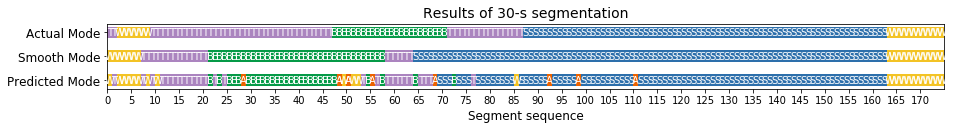

In [19]:
# display result
instance = 'zj20140414_1.txt'
y_pred, y_smth, y_test = res.loc[instance,'y_pred'],res.loc[instance,'y_smth'], res.loc[instance,'y_test']
display_modes(y_pred,y_smth,y_test)

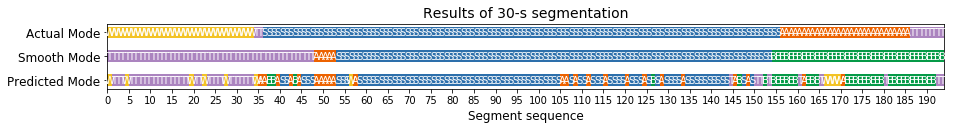

In [20]:
instance = 'hwh20140419_2.txt'
y_pred, y_smth, y_test = res.loc[instance,'y_pred'],res.loc[instance,'y_smth'], res.loc[instance,'y_test']
display_modes(y_pred,y_smth,y_test)

In [ ]:
if __name__ == '__main__':
    
    t0 = datetime.datetime.now()
    # split data into two parts
    dd = Data()
#     train_set, test_set = dd.random_split_data(test_size=1/3)
    
    # save the train_set and test_set
#     dd.save_dataset(train_set,data_name='train')
#     dd.save_dataset(test_set,data_name='test')
    train_set, test_set = dd.read_dataset('train'), dd.read_dataset('test')    
    
    
    c = []
    for step_size in [1,5,10,15,30,40,50,60,80,100,120,150]:
        # segmentation
        ss = Segmentation(step_size, start_point=0, overlap=0)

        # training
        rf = RandomForestClassifier(n_estimators=500,)  # model
        tt = Trainer(ss,rf,train_set)  # Segmentation, model, train_set
        x_train, y_train = tt.data_xy(train_set)
        rf = rf.fit(x_train,y_train)


        # predict and test
        res_df = tt.predict_set(rf,test_set)
        accuracy = tt.comprehensive_accuracy(res_df)
        c.append([step_size,accuracy])
        print(step_size)
    
    print('spent time: {}'.format(datetime.datetime.now()-t0))

1. 判断是多方式还是单方式；
2. 起始位置与重合阈值